In [ ]:
#Import Libraries
import tensorflow as tf
import numpy as np #Linear Algebra
import matplotlib.pyplot as plt #Data visualization
import pandas as pd #data manipulation

import warnings
warnings.filterwarnings('ignore') #Ignore warnings

#Make sure Tensorflow is version 2.0 or higher
print('Tensorflow Version:', tf.__version__)

Tensorflow Version: 2.15.0


In [ ]:
import pandas as pd

# Assuming 'pollution' DataFrame is filtered for desired time period and city
# Replace these lines with your actual code to load and filter the data
pollution = pd.read_csv("/content/AirPollution.xlsx - Sheet5.csv")
pollution['Date'] = pd.to_datetime(pollution[['Year', 'Month', 'Day']])
pollution.set_index('Date', inplace=True)
pollution = pollution[(pollution.City == 'PORT ALLEN') &
                      (pollution.index >= '2011-01-01') &
                      (pollution.index <= '2018-12-31')]
pollution = pollution.drop(['City', 'Year', 'Month', 'Day'], axis=1)

# Create a dictionary with dates and pm25 values
pm25_dict = {'Date': pd.date_range(start="2011-01-01", end="2018-12-31", freq="D"),
             'pm25': pollution['pm25'].tolist()}  # Assuming 'pm25' is the column with pm25 values

print(pm25_dict)


{'Date': DatetimeIndex(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
               '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
               '2011-01-09', '2011-01-10',
               ...
               '2018-12-22', '2018-12-23', '2018-12-24', '2018-12-25',
               '2018-12-26', '2018-12-27', '2018-12-28', '2018-12-29',
               '2018-12-30', '2018-12-31'],
              dtype='datetime64[ns]', length=2922, freq='D'), 'pm25': [35.0, 32.0, 75.0, 169.0, 83.0, 77.0, 61.0, 58.0, 76.0, 96.0, 95.0, 87.0, 102.0, 131.0, 136.0, 137.0, 113.0, 112.0, 86.0, 94.0, 67.0, 98.0, 177.0, 80.0, 64.0, 90.0, 89.0, 101.0, 104.0, 226.0, 95.0, 88.0, 84.0, 62.0, 46.0, 71.0, 84.0, 50.0, 50.0, 51.0, 82.0, 69.0, 85.0, 78.0, 91.0, 131.0, 138.0, 129.0, 133.0, 143.0, 80.0, 91.0, 153.0, 146.0, 127.0, 130.0, 101.0, 71.0, 113.0, 132.0, 166.0, 99.0, 74.0, 54.0, 87.0, 125.0, 79.0, 81.0, 91.0, 99.0, 96.0, 60.0, 99.0, 75.0, 114.0, 140.0, 84.0, 79.0, 77.0, 129.0, 50.0, 132.0, 96.0, 119

In [ ]:
#Impute the missing value
# Checks for and imputes missing dates
a = pd.date_range(start="2011-01-01", end="2018-12-31", freq="D")  # Continuous dates
b = pollution.index  # Our time series
diff_dates = a.difference(b)  # Finds what in 'a' is not in 'b'

td = pd.Timedelta(1, "d")  # 1 day
for date in diff_dates:
    prev_date = date - td
    if prev_date in pollution.index:
        prev_val = pollution.loc[prev_date, 'pm25']  # Takes the previous pm25 value if it exists
        pollution.loc[date, 'pm25'] = prev_val  # Imputes previous pm25 value for the missing date

pollution.sort_index(inplace=True)
pollution.index.freq = "D"  # Sets the time index frequency as daily

print(pollution.head())


             pm25
Date             
2011-01-01   35.0
2011-01-02   32.0
2011-01-03   75.0
2011-01-04  169.0
2011-01-05   83.0


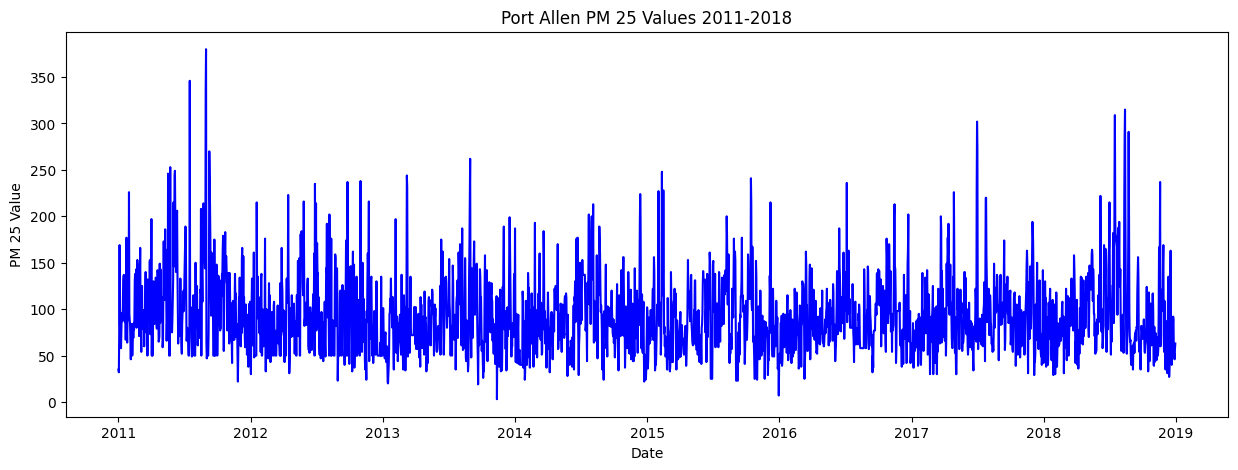

In [ ]:
#displays a plot of the pm25 values since 2018
fig = plt.figure(figsize=(15,5))
plt.plot(pollution, color='blue')
plt.xlabel('Date')
plt.ylabel('PM 25 Value')
plt.title('Port Allen PM 25 Values 2011-2018')
plt.show()

In [ ]:
#Split the time series data into a train and test set
end_train_ix = pd.to_datetime('2016-12-31')
train = pollution[:end_train_ix] # Jan 2011-2016
test = pollution[end_train_ix:] # Jan 2017-2018

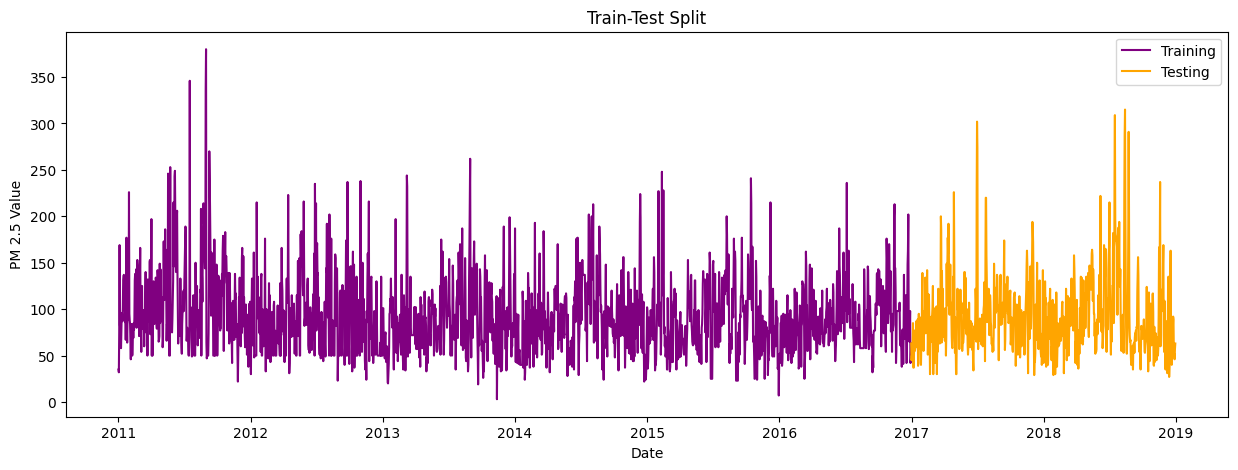

In [ ]:
#displays a plot of the train/test split
fig = plt.figure(figsize=(15,5))
plt.plot(train, color='purple', label='Training')
plt.plot(test, color='orange', label='Testing')
plt.xlabel('Date')
plt.ylabel('PM 2.5 Value')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [ ]:
#Creates a windowed dataset from the time series data
WINDOW = 14 #the window value... 14 days

#converts values to TensorSliceDataset
train_data = tf.data.Dataset.from_tensor_slices(train.values)

#takes window size + 1 slices of the dataset
train_data = train_data.window(WINDOW+1, shift=1, drop_remainder=True)

#flattens windowed data by batching
train_data = train_data.flat_map(lambda x: x.batch(WINDOW+1))

#creates features and target tuple
train_data = train_data.map(lambda x: (x[:-1], x[-1]))

#shuffles dataset
train_data = train_data.shuffle(1_000)

#creates batches of windows
train_data = train_data.batch(32).prefetch(1)

In [ ]:
from tensorflow.keras.callbacks import Callback

class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('mae') < 10.0:
            print("MAE under 10.0... Stopping training")
            self.model.stop_training = True

my_callback = CustomCallback()

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

#creates a function that updates the learning rate based on the epoch number
def scheduler(epoch, lr):
    if epoch < 2:
        return 0.01
    else:
        return lr * 0.99

lr_scheduler = LearningRateScheduler(scheduler)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Lambda, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber


lstm_model = Sequential([
    # add extra axis to input data
    Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[WINDOW]),
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(128)),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(1)
])

lstm_model.compile(
    loss=Huber(),
    optimizer=Adam(),
    metrics=['mae']
)

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 14, 1)             0         
                                                                 
 bidirectional (Bidirection  (None, 14, 256)           133120    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2

In [ ]:
#Trains LSTM Model
lstm_history = lstm_model.fit(
    train_data,
    epochs=100,
    callbacks=[lr_scheduler, my_callback],
    verbose=1
)

Epoch 1/100
69/69 [==============================] - 17s 109ms/step - loss: 34.5372 - mae: 35.0332 - lr: 0.0100
Epoch 2/100
69/69 [==============================] - 9s 123ms/step - loss: 30.7874 - mae: 31.2836 - lr: 0.0100
Epoch 3/100
69/69 [==============================] - 8s 117ms/step - loss: 31.5952 - mae: 32.0913 - lr: 0.0099
Epoch 4/100
69/69 [==============================] - 8s 106ms/step - loss: 31.1377 - mae: 31.6351 - lr: 0.0098
Epoch 5/100
69/69 [==============================] - 8s 122ms/step - loss: 30.6839 - mae: 31.1808 - lr: 0.0097
Epoch 6/100
69/69 [==============================] - 8s 109ms/step - loss: 32.2501 - mae: 32.7464 - lr: 0.0096
Epoch 7/100
69/69 [==============================] - 8s 113ms/step - loss: 31.9428 - mae: 32.4397 - lr: 0.0095
Epoch 8/100
69/69 [==============================] - 9s 122ms/step - loss: 31.5872 - mae: 32.0838 - lr: 0.0094
Epoch 9/100
69/69 [==============================] - 7s 100ms/step - loss: 30.9364 - mae: 31.4331 - lr: 0.0093


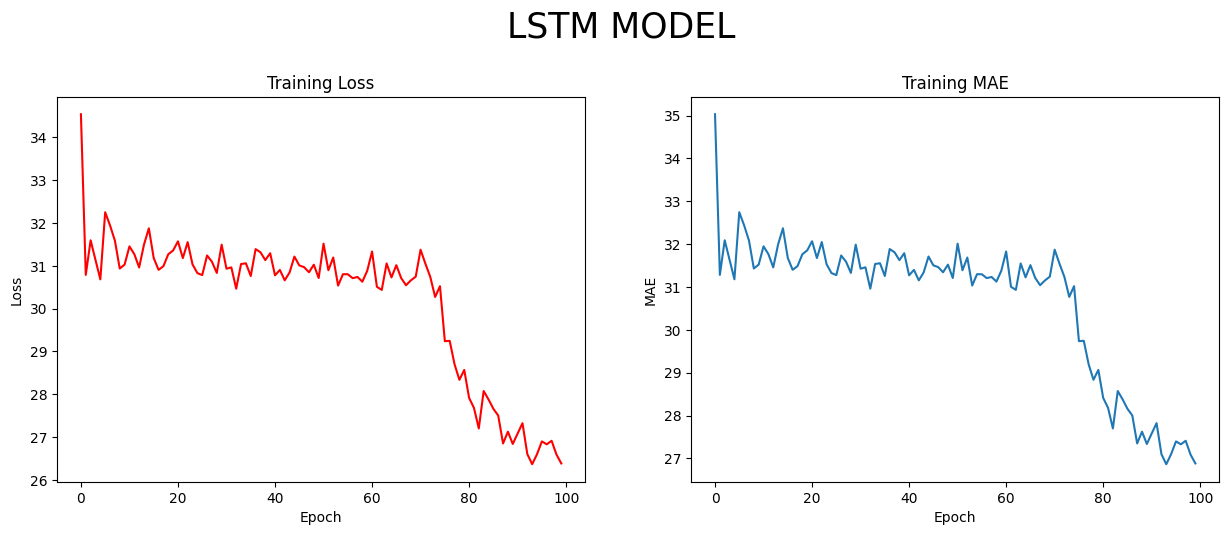

					FINAL LOSS: 26.39 | FINAL MAE: 26.88


In [ ]:
#plots training history
#Plots history of model training
plt.rcParams["figure.figsize"] = (15,5)
fig, axs = plt.subplots(1, 2)

axs[0].plot(lstm_history.history['loss'], color='red')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss')

axs[1].plot(lstm_history.history['mae'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('MAE')
axs[1].set_title('Training MAE')

fig.text(0.425,1, 'LSTM MODEL', {'size':25})
plt.show()

print("\t\t\t\t\tFINAL LOSS: {} | FINAL MAE: {}".format(
                                                round(lstm_history.history['loss'][-1], 2),
                                                 round(lstm_history.history['mae'][-1] ,2)))

In [ ]:
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, Flatten


cnn_model = Sequential([
    # add extra axis to input data
    Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[WINDOW]),
    Conv1D(filters=32, kernel_size=3, strides=1,
           padding='causal', activation='relu'),
    Conv1D(filters=64, kernel_size=3, strides=1,
           padding='causal', activation='relu'),
    GlobalAveragePooling1D(),
    Flatten(),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(1)
])

cnn_model.compile(
    loss=Huber(),
    optimizer=Adam(),
    metrics=['mae']
)

cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 14, 1)             0         
                                                                 
 conv1d (Conv1D)             (None, 14, 32)            128       
                                                                 
 conv1d_1 (Conv1D)           (None, 14, 64)            6208      
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                      

In [ ]:
#Trains CNN Model
cnn_history = cnn_model.fit(
    train_data,
    epochs=100,
    callbacks=[lr_scheduler, my_callback],
    verbose=1
)

Epoch 1/100
69/69 [==============================] - 2s 7ms/step - loss: 35.9380 - mae: 36.4349 - lr: 0.0100
Epoch 2/100
69/69 [==============================] - 1s 6ms/step - loss: 34.4078 - mae: 34.9042 - lr: 0.0100
Epoch 3/100
69/69 [==============================] - 1s 6ms/step - loss: 35.3950 - mae: 35.8904 - lr: 0.0099
Epoch 4/100
69/69 [==============================] - 1s 7ms/step - loss: 32.8836 - mae: 33.3809 - lr: 0.0098
Epoch 5/100
69/69 [==============================] - 1s 6ms/step - loss: 32.1413 - mae: 32.6383 - lr: 0.0097
Epoch 6/100
69/69 [==============================] - 1s 6ms/step - loss: 30.9404 - mae: 31.4366 - lr: 0.0096
Epoch 7/100
69/69 [==============================] - 1s 6ms/step - loss: 31.3182 - mae: 31.8148 - lr: 0.0095
Epoch 8/100
69/69 [==============================] - 1s 6ms/step - loss: 29.4610 - mae: 29.9577 - lr: 0.0094
Epoch 9/100
69/69 [==============================] - 1s 7ms/step - loss: 30.0449 - mae: 30.5412 - lr: 0.0093
Epoch 10/100
69/69 

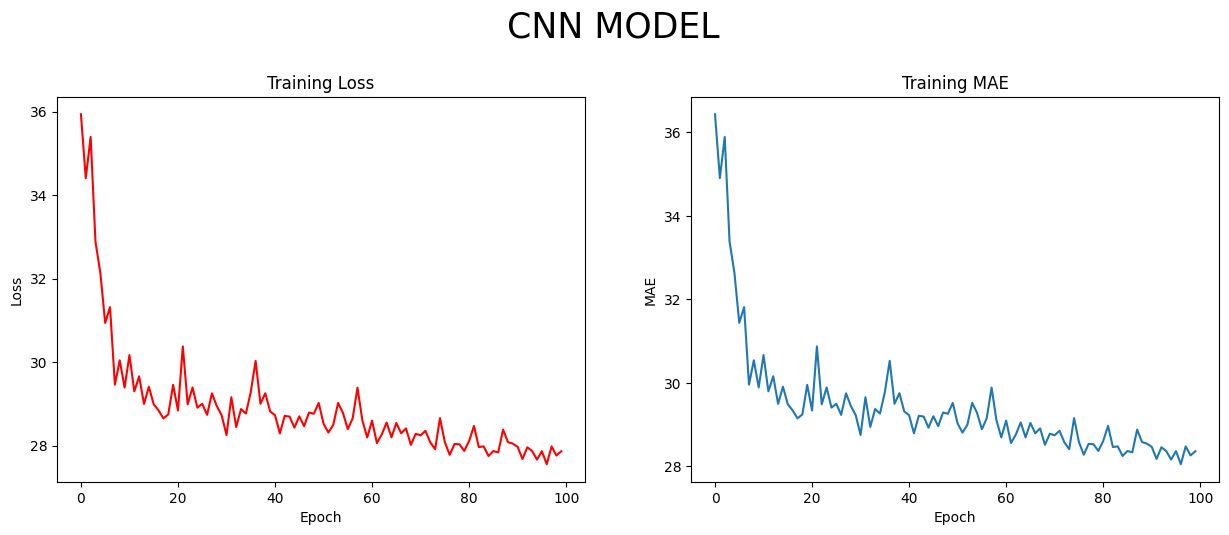

					FINAL LOSS: 27.87 | FINAL MAE: 28.36


In [ ]:
#plots training history
#Plots history of model training
plt.rcParams["figure.figsize"] = (15,5)
fig, axs = plt.subplots(1, 2)

axs[0].plot(cnn_history.history['loss'], color='red')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss')

axs[1].plot(cnn_history.history['mae'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('MAE')
axs[1].set_title('Training MAE')

fig.text(0.425,1, 'CNN MODEL', {'size':25})
plt.show()

print("\t\t\t\t\tFINAL LOSS: {} | FINAL MAE: {}".format(
                                                round(cnn_history.history['loss'][-1], 2),
                                                 round(cnn_history.history['mae'][-1], 2)))

In [ ]:
mixed_model = Sequential([
    # add extra axis to input data
    Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[WINDOW]),
    Conv1D(filters=64, kernel_size=3, strides=1,
           padding='causal', activation='relu'),
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(128)),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(1)
])


mixed_model.compile(
    loss=Huber(),
    optimizer=Adam(),
    metrics=['mae']
)

mixed_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 14, 1)             0         
                                                                 
 conv1d_2 (Conv1D)           (None, 14, 64)            256       
                                                                 
 bidirectional_2 (Bidirecti  (None, 14, 256)           197632    
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 512)              

In [ ]:
#Trains Mixed Model
mixed_history = mixed_model.fit(
    train_data,
    epochs=100,
    callbacks=[lr_scheduler, my_callback],
    verbose=1
)

Epoch 1/100
69/69 [==============================] - 18s 134ms/step - loss: 33.3083 - mae: 33.8050 - lr: 0.0100
Epoch 2/100
69/69 [==============================] - 8s 108ms/step - loss: 31.0914 - mae: 31.5882 - lr: 0.0100
Epoch 3/100
69/69 [==============================] - 7s 105ms/step - loss: 31.4776 - mae: 31.9741 - lr: 0.0099
Epoch 4/100
69/69 [==============================] - 9s 131ms/step - loss: 31.3290 - mae: 31.8247 - lr: 0.0098
Epoch 5/100
69/69 [==============================] - 9s 127ms/step - loss: 31.0588 - mae: 31.5553 - lr: 0.0097
Epoch 6/100
69/69 [==============================] - 7s 105ms/step - loss: 31.4674 - mae: 31.9644 - lr: 0.0096
Epoch 7/100
69/69 [==============================] - 8s 109ms/step - loss: 31.2471 - mae: 31.7434 - lr: 0.0095
Epoch 8/100
69/69 [==============================] - 9s 129ms/step - loss: 31.5522 - mae: 32.0478 - lr: 0.0094
Epoch 9/100
69/69 [==============================] - 8s 112ms/step - loss: 31.3287 - mae: 31.8263 - lr: 0.0093


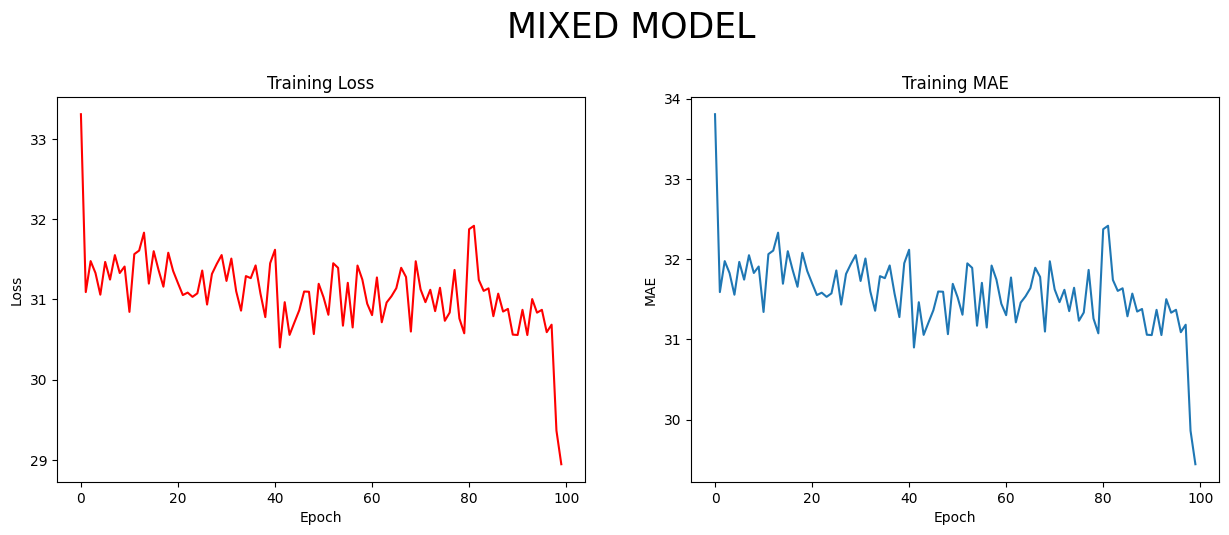

					FINAL LOSS: 28.95 | FINAL MAE: 29.44


In [ ]:
#plots training history
#Plots history of model training
plt.rcParams["figure.figsize"] = (15,5)
fig, axs = plt.subplots(1, 2)

axs[0].plot(mixed_history.history['loss'], color='red')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss')

axs[1].plot(mixed_history.history['mae'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('MAE')
axs[1].set_title('Training MAE')

fig.text(0.425,1, 'MIXED MODEL', {'size':25})
plt.show()

print("\t\t\t\t\tFINAL LOSS: {} | FINAL MAE: {}".format(
                                                round(mixed_history.history['loss'][-1], 2),
                                                 round(mixed_history.history['mae'][-1], 2)))

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

# Assuming train and test are Pandas DataFrames
# Concatenate train[-WINDOW:] and test[:-1] along rows to create forecast_data DataFrame
forecast_data = pd.concat([train[-WINDOW:], test[:-1]])

# Convert forecast_data to a NumPy array
forecast_data_array = forecast_data.values

all_models = [('LSTM MODEL', lstm_model),
              ('CNN MODEL', cnn_model),
              ('MIXED MODEL', mixed_model)]

model_forecasts = {
    'LSTM MODEL': [],
    'CNN MODEL': [],
    'MIXED MODEL': []
}

# Loop through all_models to get forecasts
for name, model in all_models:
    # Convert values to TensorSliceDataset
    test_data = tf.data.Dataset.from_tensor_slices(forecast_data_array)

    # Takes window size slices of the dataset
    test_data = test_data.window(WINDOW, shift=1, drop_remainder=True)

    # Flattens windowed data by batching
    test_data = test_data.flat_map(lambda x: x.batch(WINDOW + 1))

    # Creates batches of windows
    test_data = test_data.batch(32).prefetch(1)

    # Gets model prediction
    preds = model.predict(test_data)

    # Append to forecast dict
    model_forecasts[name].append(preds)


23/23 [==============================] - 2s 35ms/step


In [ ]:
#Gets MAE score of model forecasts

N = test.values.shape[0] #number of samples in test set

lstm_mae = np.abs(test.values - model_forecasts['LSTM MODEL'][0].squeeze()).sum() / N

cnn_mae = np.abs(test.values - model_forecasts['CNN MODEL'][0].squeeze()).sum() / N

mix_mae = np.abs(test.values - model_forecasts['MIXED MODEL'][0].squeeze()).sum() / N


print('MODEL MAE SCORES')
print('=====================================')
print('LSTM MAE:', round(lstm_mae, 2))
print('CNN MAE:', round(cnn_mae, 2))
print('MIXED MAE:', round(mix_mae, 2))

MODEL MAE SCORES
LSTM MAE: 23951.33
CNN MAE: 24024.68
MIXED MAE: 23054.02


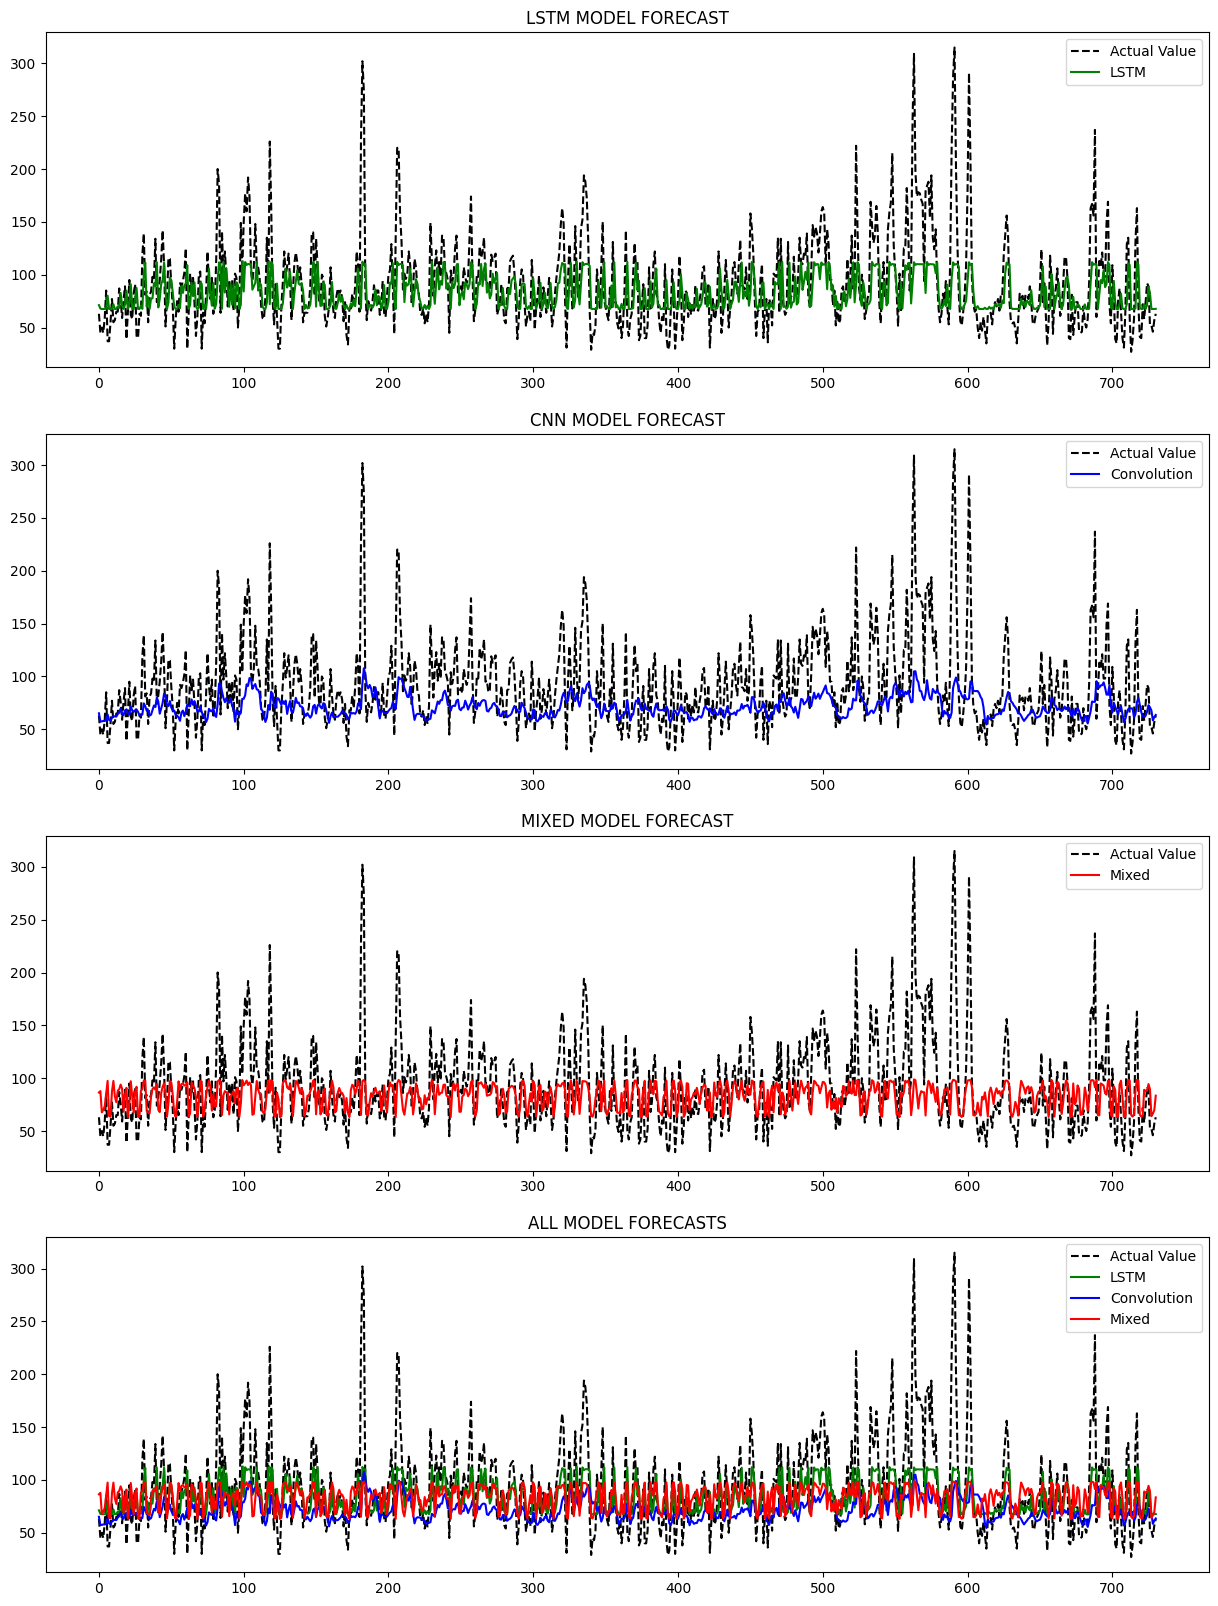

In [ ]:
#displays forecasted data
plt.rcParams["figure.figsize"] = (15,20)
fig, axs = plt.subplots(4, 1)

#LSTM Forecast
axs[0].plot(test.values, color='black', linestyle='--', label='Actual Value')
axs[0].plot(model_forecasts['LSTM MODEL'][0].squeeze(), color='green', label='LSTM')
axs[0].set_title('LSTM MODEL FORECAST')
axs[0].legend()

#CNN Forcast
axs[1].plot(test.values, color='black', linestyle='--', label='Actual Value')
axs[1].plot(model_forecasts['CNN MODEL'][0].squeeze(), color='blue', label='Convolution')
axs[1].set_title('CNN MODEL FORECAST')
axs[1].legend()

#Mixed Model Forecast
axs[2].plot(test.values, color='black', linestyle='--', label='Actual Value')
axs[2].plot(model_forecasts['MIXED MODEL'][0].squeeze(), color='red', label='Mixed')
axs[2].set_title('MIXED MODEL FORECAST')
axs[2].legend()

#All forecasts
axs[3].plot(test.values, color='black', linestyle='--', label='Actual Value')
axs[3].plot(model_forecasts['LSTM MODEL'][0].squeeze(), color='green', label='LSTM')
axs[3].plot(model_forecasts['CNN MODEL'][0].squeeze(), color='blue', label='Convolution')
axs[3].plot(model_forecasts['MIXED MODEL'][0].squeeze(), color='red', label='Mixed')
axs[3].set_title('ALL MODEL FORECASTS')
axs[3].legend()


plt.show()

In [ ]:
!pip install pysal
import pandas as pd
import geopandas as gpd
from pysal.lib import weights
from esda import moran
import numpy as np

# Load the datasets
lung_cancer = pd.read_csv('lung_cancer_data.csv')
pm25 = pd.read_csv('pm25_data.csv')

# Load the datasets
lung_cancer = pd.read_csv('lung_cancer_data.csv')
pm25 = pd.read_csv('pm25_data.csv')

# Load the shapefile
parishes_shapefile = gpd.read_file('Louisiana_Parishes.shp')

# Merge the lung cancer data with the shapefile
lung_cancer = pd.merge(lung_cancer, parishes_shapefile[['Name', 'geometry']], left_on='Parish', right_on='Name')

# Merge the PM2.5 data with the shapefile
pm25 = pd.merge(pm25, parishes_shapefile[['Name', 'geometry']], left_on='Parish', right_on='Name')

# Group the PM2.5 data by parish and year, and calculate the mean
pm25['pm2.5'] = pd.to_numeric(pm25['pm2.5'], errors='coerce')
pm25_grouped = pm25.groupby(['Parish', 'Year'])['pm2.5'].mean().reset_index()

# Merge the lung cancer data with the grouped PM2.5 data
combined_data = pd.merge(lung_cancer, pm25_grouped, on=['Parish', 'Year'])

# Convert combined_data to a GeoDataFrame
combined_data = gpd.GeoDataFrame(combined_data, geometry='geometry')

#  replace occurrences of the character '^' in the 'Rate' column of the DataFrame 'lung_cancer' with NaN (Not a Number)
lung_cancer['Rate'] = lung_cancer['Rate'].replace('^', np.nan) #

# converting the values in the 'Rate' column of the DataFrame 'combined_data' into numeric type
combined_data['Rate'] = pd.to_numeric(combined_data['Rate'], errors='coerce')

# Drop rows with NaN values in the 'Rate' column
combined_data_no_nan = combined_data.dropna(subset=['Rate'])

# Convert 'Rate' column to float
combined_data_no_nan['Rate'] = combined_data_no_nan['Rate'].astype(float)


# Create a spatial weight matrix using combined_data_no_nan
weights_matrix = weights.Queen.from_dataframe(combined_data, ids=combined_data.index)

# Calculate Moran's I for lung cancer rate
lung_cancer_moran = moran.Moran(combined_data_no_nan['Rate'], weights_matrix_no_nan)

# Calculate Moran's I for PM2.5 value
pm25_moran = moran.Moran(combined_data['pm2.5'], weights_matrix)

print(f"Moran's I for lung cancer rate: {lung_cancer_moran.I}")
print(f"Moran's I for PM2.5 value: {pm25_moran.I}")

# Visualize the spatial distribution
import folium

# Create a base map
base_map = folium.Map(location=[combined_data.geometry.centroid.y.mean(), combined_data.geometry.centroid.x.mean()], zoom_start=8)

# Add choropleth layers for lung cancer rate and PM2.5 value
#The first choropleth map represents the lung cancer rate using a color scale ranging from yellow to red
#the second one represents PM2.5 values using a color scale ranging from purple to blue
# utilized for visualizing spatial variations in both lung cancer rates and PM2.5 values on the map, with distinct color schemes.
folium.Choropleth(
    geo_data=combined_data,
    data=combined_data,
    columns=['Parish', 'Rate'],
    key_on='feature.properties.Parish',
    fill_color='YlOrRd',
    legend_name='Lung Cancer Rate'
).add_to(base_map)

folium.Choropleth(
    geo_data=combined_data,
    data=combined_data,
    columns=['Parish', 'pm2.5'],
    key_on='feature.properties.Parish',
    fill_color='PuBu',
    legend_name='PM2.5 Value'
).add_to(base_map)

# Display the map
base_map

Moran's I for lung cancer rate: -0.07142857142857144
Moran's I for PM2.5 value: -0.06666666666666668


#Multivariate To find the corelation about cancer, pm2.5 and copd(Final Project Implementation)

In [ ]:
df = pd.read_csv('/content/PM2.5_Cancer_COPD.csv')

In [ ]:
# Get unique values for the 'County' column
unique_counties = df['County'].unique()
print(unique_counties)

['ACADIA' 'ALLEN' 'ASCENSION' 'ASSUMPTION' 'AVOYELLES' 'BEAUREGARD'
 'BIENVILLE' 'BOSSIER' 'CADDO' 'CALCASIEU' 'CALDWELL' 'CAMERON'
 'CATAHOULA' 'CLAIBORNE' 'CONCORDIA' 'DE SOTO' 'EAST BATON ROUGE'
 'EAST CARROLL' 'EAST FELICIANA' 'EVANGELINE' 'FRANKLIN' 'GRANT' 'IBERIA'
 'IBERVILLE' 'JACKSON' 'JEFFERSON' 'JEFFERSON DAVIS' 'LAFAYETTE'
 'LAFOURCHE' 'LINCOLN' 'LIVINGSTON' 'MADISON' 'MOREHOUSE' 'NATCHITOCHES'
 'ORLEANS' 'OUACHITA' 'PLAQUEMINES' 'POINTE COUPEE' 'RAPIDES' 'RED RIVER'
 'RICHLAND' 'SABINE' 'TANGIPAHOA' 'TENSAS' 'TERREBONNE' 'UNION'
 'VERMILION' 'VERNON' 'WASHINGTON' 'WEBSTER' 'WEST BATON ROUGE'
 'WEST CARROLL' 'WEST FELICIANA' 'WINN']


In [ ]:
df

CountyFIPS_Year  County  PM2.5Value  Year CancerRate CancerCount  \
0        22001_2010  ACADIA         9.7  2010       78.9          54   
1        22001_2011  ACADIA         9.4  2011       80.9          54   
2        22003_2010   ALLEN         9.6  2010       73.8          20   
3        22001_2012  ACADIA         9.5  2012       77.6          53   
4        22001_2013  ACADIA         9.4  2013         86          58   
..              ...     ...         ...   ...        ...         ...   
535      22127_2015    WINN         9.1  2015          ^           ^   
536      22127_2016    WINN         8.9  2016          ^           ^   
537      22127_2017    WINN         9.2  2017          ^           ^   
538      22127_2018    WINN         9.6  2018      106.3          22   
539      22127_2019    WINN         9.0  2019          ^           ^   

     TotalPopulation COPDCount  
0              61876       246  
1              61872       206  
2              25704        87  
3              62007       231  
4              62310       214  
..               ...       ...  
535            14646        39  
536            14539        48  
537            14355        52  
538            14132        53  
539            13961        42  

[540 rows x 8 columns]

In [ ]:
df.query('CancerCount!=CancerCount').count()

CountyFIPS_Year    0
County             0
PM2.5Value         0
Year               0
CancerRate         0
CancerCount        0
TotalPopulation    0
COPDCount          0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CountyFIPS_Year  540 non-null    object 
 1   County           540 non-null    object 
 2   PM2.5Value       540 non-null    float64
 3   Year             540 non-null    int64  
 4   CancerRate       540 non-null    object 
 5   CancerCount      540 non-null    object 
 6   TotalPopulation  540 non-null    int64  
 7   COPDCount        540 non-null    object 
dtypes: float64(1), int64(2), object(5)
memory usage: 33.9+ KB


In [ ]:
df.isnull().any()

CountyFIPS_Year    False
County             False
PM2.5Value         False
Year               False
CancerRate         False
CancerCount        False
TotalPopulation    False
COPDCount          False
dtype: bool

In [ ]:
import pandas as pd
import plotly.express as px

# Assuming df is your DataFrame with columns 'CountyFIPS_Year', 'Year', 'PM2.5Value', 'CancerCount', 'COPDCount', 'TotalPopulation'

# Replace 'Suppressed', '^', and NaN with NaN in 'COPDCount' column
df['COPDCount'] = df['COPDCount'].replace(['Suppressed', '^', np.nan], pd.NA)

# Replace 'Suppressed', '^', and NaN with NaN in 'CancerCount' column
df['CancerCount'] = df['CancerCount'].replace(['^', np.nan], pd.NA)

# Convert columns to numeric
df['COPDCount'] = pd.to_numeric(df['COPDCount'], errors='coerce')
df['CancerCount'] = pd.to_numeric(df['CancerCount'], errors='coerce')

# Impute missing values in 'COPDCount' and 'CancerCount' using the mean value by Year
df['COPDCount'] = df.groupby('Year')['COPDCount'].transform(lambda x: x.fillna(x.mean()))
df['CancerCount'] = df.groupby('Year')['CancerCount'].transform(lambda x: x.fillna(x.mean()))

# Plotting PM2.5Value
pm25_fig = px.line(df, x='CountyFIPS_Year', y='PM2.5Value', color='Year', title='PM2.5Value for Each Year',hover_data=['County', 'Year'])
pm25_fig.show()

# Plotting CancerCount
cancer_fig = px.line(df, x='CountyFIPS_Year', y='CancerCount', color='Year', title='CancerCount for Each Year',hover_data=['County', 'Year'])
cancer_fig.show()

# Plotting COPDCount
copd_fig = px.line(df, x='CountyFIPS_Year', y='COPDCount', color='Year', title='COPDCount for Each Year',hover_data=['County', 'Year'])
copd_fig.show()


In [ ]:
!pip install plotly
import pandas as pd
import plotly.graph_objects as go

# Assuming df is your DataFrame with columns 'CountyFIPS_Year', 'Year', 'PM2.5Value', 'CancerCount', 'COPDCount', 'TotalPopulation'

# Replace 'Suppressed', '^', and NaN with NaN in 'COPDCount' column
df['COPDCount'] = df['COPDCount'].replace(['Suppressed', '^', np.nan], pd.NA)

# Replace 'Suppressed', '^', and NaN with NaN in 'CancerCount' column
df['CancerCount'] = df['CancerCount'].replace(['^', np.nan], pd.NA)

# Convert columns to numeric
df['COPDCount'] = pd.to_numeric(df['COPDCount'], errors='coerce')
df['CancerCount'] = pd.to_numeric(df['CancerCount'], errors='coerce')

# Impute missing values in 'COPDCount' and 'CancerCount' using the mean value by Year
df['COPDCount'] = df.groupby('Year')['COPDCount'].transform(lambda x: x.fillna(x.mean()))
df['CancerCount'] = df.groupby('Year')['CancerCount'].transform(lambda x: x.fillna(x.mean()))

# Filter data for each year separately
years = range(2010, 2020)  # From 2011 to 2019
data_years = [df[df['Year'] == year] for year in years]

fig = go.Figure()

for data_year in data_years:
    fig.add_trace(go.Scatter(x=data_year['CountyFIPS_Year'], y=data_year['PM2.5Value'],
                             mode='lines',
                             name=f'PM2.5Value - {data_year["Year"].unique()[0]}',
                             hovertemplate='<b>Year:</b> %{text[0]}<br>'
                                           '<b>CountyFIPS:</b> %{text[1]}<br>'
                                           '<b>PM2.5Value:</b> %{y:.2f}<extra></extra>',
                             text=data_year[['Year', 'CountyFIPS_Year']],
                             ))
    fig.add_trace(go.Scatter(x=data_year['CountyFIPS_Year'], y=data_year['CancerCount'],
                             mode='lines',
                             name=f'CancerCount - {data_year["Year"].unique()[0]}',
                             hovertemplate='<b>Year:</b> %{text[0]}<br>'
                                           '<b>CountyFIPS:</b> %{text[1]}<br>'
                                           '<b>CancerCount:</b> %{y:.2f}<extra></extra>',
                             text=data_year[['Year', 'CountyFIPS_Year']],
                             ))
    fig.add_trace(go.Scatter(x=data_year['CountyFIPS_Year'], y=data_year['COPDCount'],
                             mode='lines',
                             name=f'COPDCount - {data_year["Year"].unique()[0]}',
                             hovertemplate='<b>Year:</b> %{text[0]}<br>'
                                           '<b>CountyFIPS:</b> %{text[1]}<br>'
                                           '<b>COPDCount:</b> %{y:.2f}<extra></extra>',
                             text=data_year[['Year', 'CountyFIPS_Year']],
                             ))

fig.update_layout(title='PM2.5, Cancer, and COPD Counts for Each Year (2010-2019)',
                  xaxis_title='CountyFIPS_Year',
                  yaxis_title='Count',
                  hovermode='closest')

fig.show()


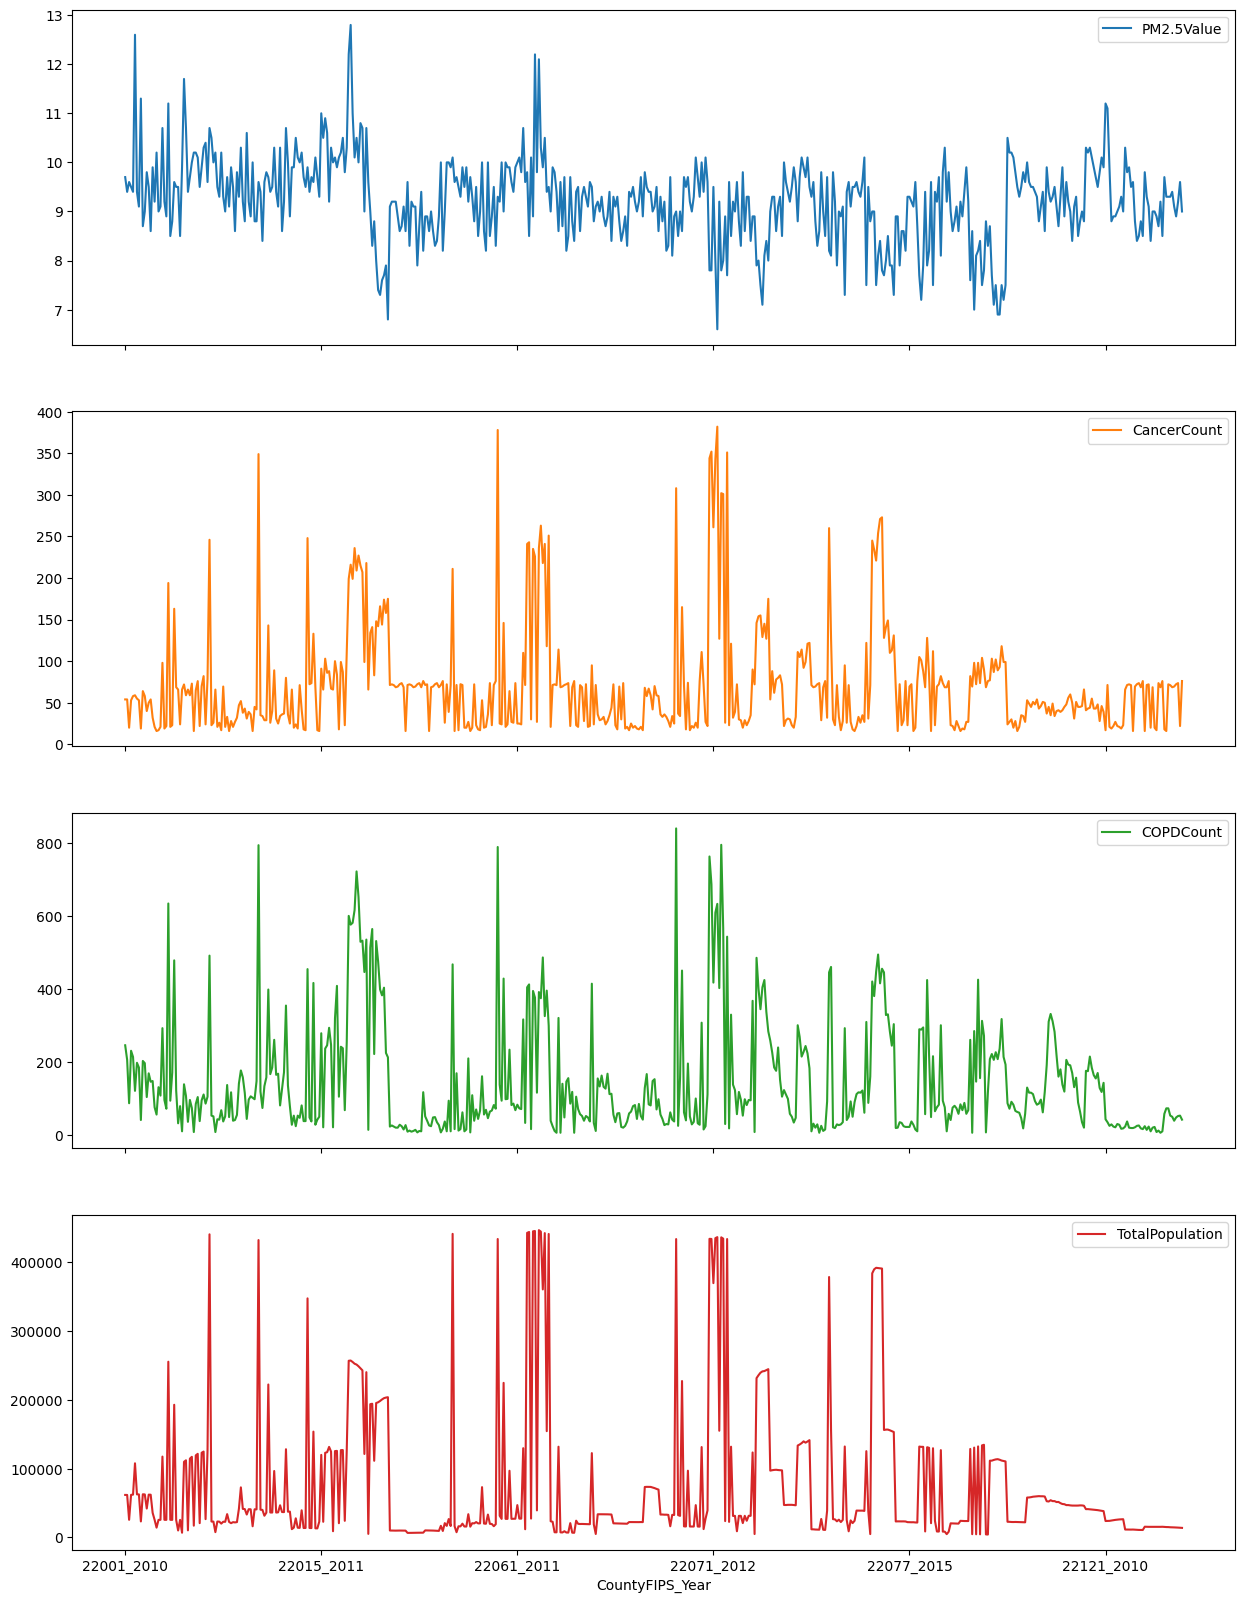

County  PM2.5Value  Year CancerRate  CancerCount  \
CountyFIPS_Year                                                     
22001_2010       ACADIA         9.7  2010       78.9    54.000000   
22001_2011       ACADIA         9.4  2011       80.9    54.000000   
22003_2010        ALLEN         9.6  2010       73.8    20.000000   
22001_2012       ACADIA         9.5  2012       77.6    53.000000   
22001_2013       ACADIA         9.4  2013         86    58.000000   
...                 ...         ...   ...        ...          ...   
22127_2015         WINN         9.1  2015          ^    69.500000   
22127_2016         WINN         8.9  2016          ^    72.300000   
22127_2017         WINN         9.2  2017          ^    73.625000   
22127_2018         WINN         9.6  2018      106.3    22.000000   
22127_2019         WINN         9.0  2019          ^    76.121951   

                 TotalPopulation  COPDCount  
CountyFIPS_Year                              
22001_2010                 61876      246.0  
22001_2011                 61872      206.0  
22003_2010                 25704       87.0  
22001_2012                 62007      231.0  
22001_2013                 62310      214.0  
...                          ...        ...  
22127_2015                 14646       39.0  
22127_2016                 14539       48.0  
22127_2017                 14355       52.0  
22127_2018                 14132       53.0  
22127_2019                 13961       42.0  

[540 rows x 7 columns]

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Replace 'Suppressed', '^', and NaN with NaN in 'COPDCount' column
df['COPDCount'] = df['COPDCount'].replace(['Suppressed', '^', np.nan], pd.NA)

# Replace 'Suppressed', '^', and NaN with NaN in 'CancerCount' column
df['CancerCount'] = df['CancerCount'].replace(['^', np.nan], pd.NA)

# Convert columns to numeric
df['COPDCount'] = pd.to_numeric(df['COPDCount'], errors='coerce')
df['CancerCount'] = pd.to_numeric(df['CancerCount'], errors='coerce')

# Impute missing values in 'COPDCount' and 'CancerCount' using the mean value by FIPS code
df['COPDCount'] = df.groupby('Year')['COPDCount'].transform(lambda x: x.fillna(x.mean()))
df['CancerCount'] = df.groupby('Year')['CancerCount'].transform(lambda x: x.fillna(x.mean()))


# Set the index inplace
df.set_index('CountyFIPS_Year', inplace=True)

# Plotting all columns (including the new columns)
df[['PM2.5Value', 'CancerCount', 'COPDCount', 'TotalPopulation']].plot(subplots=True)
plt.show()

df


#Multivariate for finding the corelation of other factors and pm2.5

In [ ]:
# Load data from Excel file
file_path = '/content/CancerFactorsData.xlsx'
df = pd.read_excel(file_path)

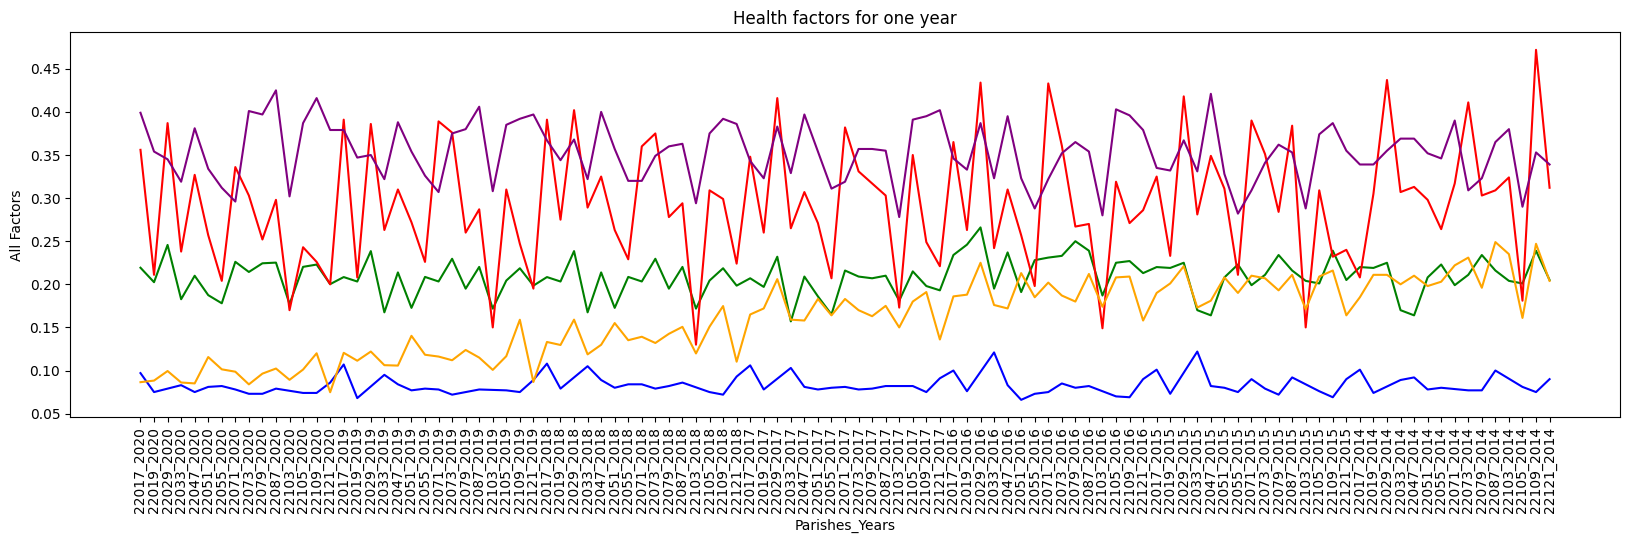

In [ ]:
#Plots all the health factors
plt.figure(figsize=(20,5))
plt.plot(df["ID"], df["PM2.5"], color='blue')
plt.plot(df["ID"], df["Smoking"], color='green')
plt.plot(df["ID"], df["Poverty"], color='red')
plt.plot(df["ID"], df["Obesity"], color='purple')
plt.plot(df["ID"], df["Uninsured"], color='orange')
plt.xlabel('Parishes_Years')
plt.xticks(rotation='vertical')
plt.ylabel('All Factors')
plt.title('Health factors for one year')
plt.show()

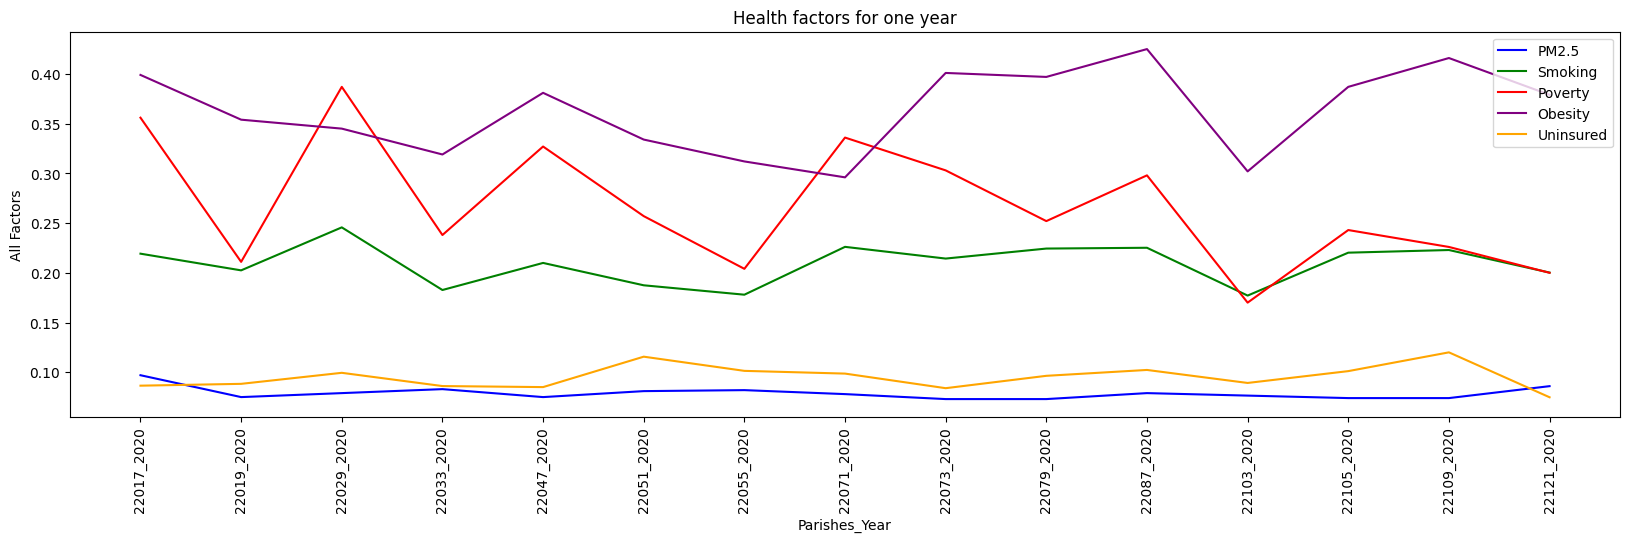

In [ ]:
#Plots all the health factors based on one year
df_filtered = df[df['ID'].astype(str).str.endswith('2020')]
plt.figure(figsize=(20, 5))

# Plotting selected rows
plt.plot(df_filtered["ID"], df_filtered["PM2.5"], color='blue', label='PM2.5')
plt.plot(df_filtered["ID"], df_filtered["Smoking"], color='green', label='Smoking')
plt.plot(df_filtered["ID"], df_filtered["Poverty"], color='red', label='Poverty')
plt.plot(df_filtered["ID"], df_filtered["Obesity"], color='purple', label='Obesity')
plt.plot(df_filtered["ID"], df_filtered["Uninsured"], color='orange', label='Uninsured')

plt.xlabel('Parishes_Year')
plt.xticks(rotation='vertical')
plt.ylabel('All Factors')
plt.title('Health factors for one year')
plt.legend()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
# Mutlivariate Regression
# Define your input features and target variable
features = ['Smoking', 'Obesity', 'Poverty', 'Uninsured', 'PM2.5']
target = 'LungCancerRates'

# Split the data into training and testing sets
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating Sequential model
model = Sequential()

# Adding Dense layers to create a deep neural network
model.add(Dense(64, input_shape=(len(features),), activation='relu'))  # Input layer with 64 neurons and ReLU activation
model.add(Dense(32, activation='relu'))  # Hidden layer with 32 neurons and ReLU activation
model.add(Dense(1))  # Output layer with 1 neuron (for regression task)

# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])  # Using Adam optimizer and Mean Squared Error loss

# Training the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)

# Evaluating the model
loss, mae = model.evaluate(X_test, y_test)

# Making predictions
predictions = model.predict(X_test)

# Printing sample predicted and actual values for comparison
for i in range(5):
    print(f"Predicted: {predictions[i][0]}, Actual: {y_test.iloc[i]}")

1/1 [==============================] - 0s 119ms/step
Predicted: 0.8180130124092102, Actual: 0.851483927
Predicted: 0.7403320670127869, Actual: 0.874412004
Predicted: 0.8120816349983215, Actual: 0.851970181
Predicted: 0.789171040058136, Actual: 0.705521669
Predicted: 0.7951587438583374, Actual: 0.87335535


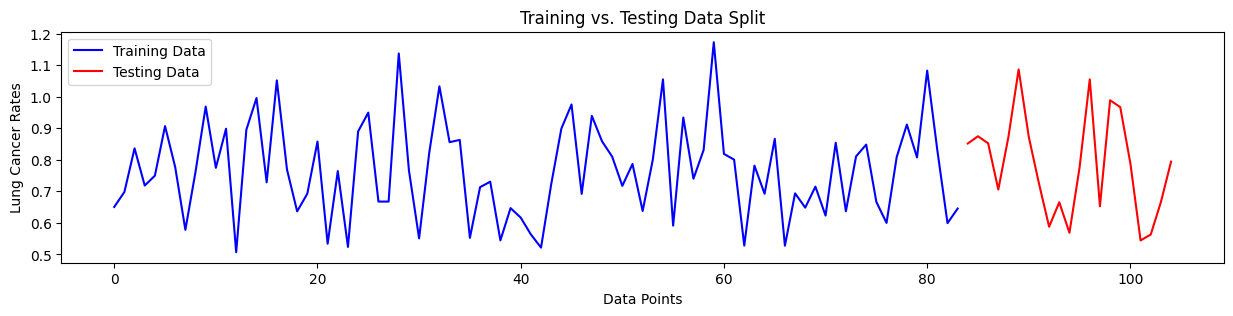

In [ ]:
import matplotlib.pyplot as plt

# Generate indices for training and testing data points
train_indices = range(len(X_train))
test_indices = range(len(X_train), len(X_train) + len(X_test))

plt.figure(figsize=(15, 3))

# Plot training data as a line
plt.plot(train_indices, y_train, label='Training Data', color='blue')

# Plot testing data as a line
plt.plot(test_indices, y_test, label='Testing Data', color='red')

plt.xlabel('Data Points')
plt.ylabel('Lung Cancer Rates')
plt.title('Training vs. Testing Data Split')
plt.legend()
plt.show()

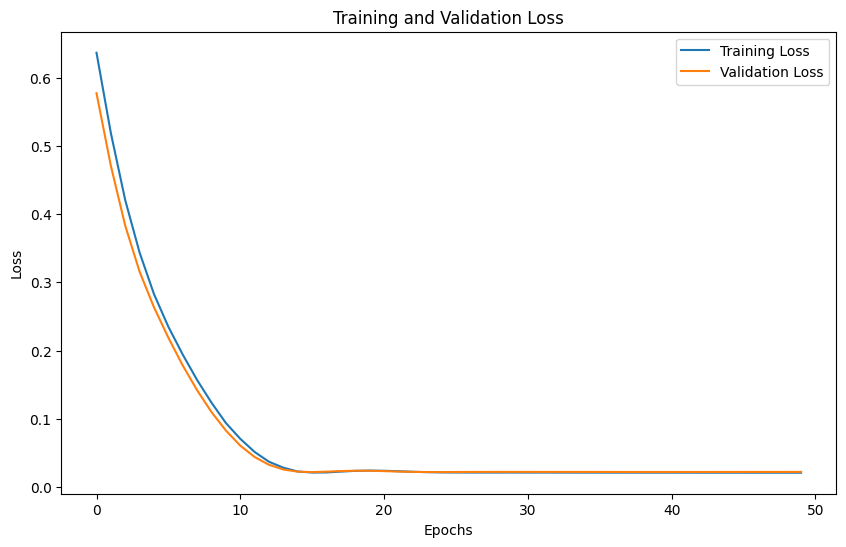

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

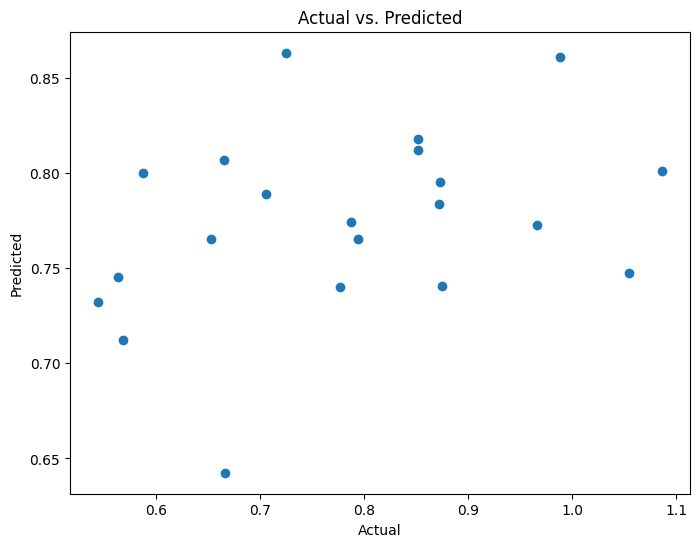

In [ ]:
#Create a plot to visualize predictions vs. actuals
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()

#Morans'I value for pm2.5 and cancer data and interactive map

In [ ]:
!pip install pysal

In [ ]:
!pip install contextily

In [ ]:
import pandas as pd
import geopandas as gpd
import folium
from pysal.explore import esda
from pysal.lib import weights
from ipywidgets import interact, IntSlider
import matplotlib.pyplot as plt
import contextily as ctx
import os
# Load the Louisiana parish boundary data
parishes_geo = gpd.read_file('/content/Louisiana_Parishes.shp')

# Specify the parishes of interest
parishes = ['Ascension', 'Caddo', 'Calcasieu', 'East Baton Rouge', 'Iberville',
            'Jefferson', 'Lafayette', 'Ouachita', 'Rapides', 'St. Bernard',
            'Tangipahoa', 'Terrebonne', 'West Baton Rouge']

# Filter the parishes_geo GeoDataFrame to include only the parishes present in the datasets
parishes_geo_filtered = parishes_geo[parishes_geo['Name'].isin(parishes)]

def create_maps(year):
    # Load the PM2.5 data for the selected year
    pm25_file = f'/content/pm2.5_{year}.csv'
    data = pd.read_csv(pm25_file)
    print(data)
    if os.path.exists(pm25_file):
      data = pd.read_csv(pm25_file)
    else:
      print(f"File not found: {pm25_file}")
    # Load the lung cancer data for the selected year
    cancer_file = f'/content/lung_cancer_{year}.csv'
    cancer_data = pd.read_csv(cancer_file)
    print(cancer_data)
    # Filter the data for the selected year and specified parishes
    data_filtered = data[(data['Year'] == year) & (data['Name'].isin(parishes))]
    cancer_data_filtered = cancer_data[(cancer_data['Year'] == year) & (cancer_data['Name'].isin(parishes))]

    # Merge the PM2.5 data with the filtered parish boundary data
    merged_data = parishes_geo_filtered.merge(data_filtered, left_on='Name', right_on='Name')

    # Merge the lung cancer data
    merged_data = merged_data.merge(cancer_data_filtered, left_on='Name', right_on='Name')

    # Calculate Moran's I for spatial autocorrelation
    w = weights.Queen.from_dataframe(merged_data)
    moran_pm25 = esda.Moran(merged_data['Mean'], w)
    moran_cancer = esda.Moran(merged_data['Rate'], w)

    # Create the non-interactive map
    fig, ax = plt.subplots(figsize=(10, 8))
    merged_data.plot(ax=ax, edgecolor='black', column='Rate', cmap='Reds', legend=True)
    merged_data.centroid.plot(ax=ax, markersize=merged_data['Mean'], color='black', alpha=0.7)
    ctx.add_basemap(ax)
    ax.set_title(f'PM2.5 Mean for Louisiana Parishes in {year}')
    ax.set_axis_off()

    # Create the interactive map centered on Louisiana
    louisiana_coords = [30.9843, -91.9623] # Coordinates for the center of Louisiana
    interactive_map = folium.Map(location=louisiana_coords, zoom_start=7)

    # Add the filtered parish polygons to the map
    folium.GeoJson(
        parishes_geo_filtered,
        name='Parishes',
        style_function=lambda feature: {
            'fillColor': 'white',
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.2
        }
    ).add_to(interactive_map)

    # Add parish polygons to the map and shade them based on lung cancer rates
    folium.Choropleth(
        geo_data=merged_data,
        name='Lung Cancer Rates',
        data=merged_data,
        columns=['Name', 'Rate'],
        key_on='feature.properties.Name',
        fill_color='YlOrRd',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='Lung Cancer Rates'
    ).add_to(interactive_map)

    # Create a feature group for PM2.5 mean values
    pm25_group = folium.FeatureGroup(name='PM2.5 Mean Values')

    # Add red circles for PM2.5 mean values
    for idx, row in merged_data.iterrows():
        folium.Circle(
            location=[row.geometry.centroid.y, row.geometry.centroid.x],
            radius=5000, # Adjust the radius as needed
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=1,
            tooltip=f"Parish: {row['Name']}<br>PM2.5 Mean: {row['Mean']:.2f}"
        ).add_to(pm25_group)

    # Add the PM2.5 feature group to the map
    pm25_group.add_to(interactive_map)

    # Add a layer control to the map
    folium.LayerControl().add_to(interactive_map)

    # Display Moran's I values
    print(f"Moran's I for PM2.5 in {year}: {moran_pm25.I:.4f}")
    print(f"Moran's I p-value for PM2.5 in {year}: {moran_pm25.p_sim:.4f}")
    print(f"Moran's I for Lung Cancer Rates in {year}: {moran_cancer.I:.4f}")
    print(f"Moran's I p-value for Lung Cancer Rates in {year}: {moran_cancer.p_sim:.4f}")

    return fig, interactive_map

# Create the interactive dashboard
@interact(year=IntSlider(min=2011, max=2020, step=1, value=2011))
def display_dashboard(year):
    fig, interactive_map = create_maps(year)
    plt.show(fig)
    display(interactive_map)

#Predicted PM2.5 Values for Parishes in January 2022 with LSTM(3d input and output)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import plotly.graph_objects as go

# Load PM2.5 data
pm25_file = '/content/Monthly_PM25_Values_2011_2021.csv'
pm25_data = pd.read_csv(pm25_file)

# Split the 'Date' column into 'Year' and 'Month' columns
pm25_data[['Year', 'Month']] = pm25_data['Date'].str.split('/', expand=True)
# Check for missing values in the 'Year' column
missing_values = pm25_data['Year'].isnull().sum()
if missing_values > 0:
    print("There are missing values in the 'Year' column.")
# Drop rows with missing values in the 'Year' column
pm25_data.dropna(subset=['Year'], inplace=True)
# Recalculate last_date_year after handling missing values
last_date_index = pm25_data.index[-1]
last_date_year = int(pm25_data.loc[last_date_index, 'Year'])

# Preprocess data for LSTM
pm25_values = pm25_data['PM2.5'].values.reshape(-1, 1)  # 'PM2.5' column contains mean PM2.5 values
scaler = MinMaxScaler(feature_range=(0, 1))
pm25_scaled = scaler.fit_transform(pm25_values)
#PM2.5 Data: [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65]
#if time steps 3
#X = [[10, 15, 20], [15, 20, 25], [20, 25, 30], [25, 30, 35], ...]
# y = [25, 30, 35, 40, ...]

# Prepare data for LSTM (3D input)
time_steps = 10  # Define the number of time steps (adjust as needed)
X = []
y = []
for i in range(len(pm25_scaled) - time_steps):
    X.append(pm25_scaled[i:i+time_steps, 0])
    y.append(pm25_scaled[i+time_steps, 0])

X = np.array(X)
y = np.array(y)

# Reshape data for LSTM (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
model.fit(X, y, epochs=100, batch_size=32)

# Make predictions for January 2022 (monthly predictions)
predicted_values = []
initial_sequence = X[-1]  # Initial sequence for prediction
for _ in range(1):  # Predicting for January 2022
    predicted_value = model.predict(initial_sequence.reshape(1, time_steps, 1))
    predicted_values.append(predicted_value.flatten()[0])  # Append predicted value
    initial_sequence = np.append(initial_sequence[1:], predicted_value)  # Update sequence for next prediction

# Inverse transform the predictions (if needed)
predicted_values = np.array(predicted_values).reshape(-1, 1)
predicted_values = scaler.inverse_transform(predicted_values)

# Get latitude and longitude for each parish
parish_latitudes = pm25_data['Latitude'].values
parish_longitudes = pm25_data['Longitude'].values
parish_names = pm25_data['Parish'].values  # Get parish names

# Create a Plotly scattermapbox plot for the predicted values
fig = go.Figure(go.Scattermapbox(
    lat=parish_latitudes,
    lon=parish_longitudes,
    mode='markers',
    marker=go.scattermapbox.Marker(
        size=10,
        color=predicted_values.flatten(),  # Color based on predicted PM2.5 values
        colorscale='Viridis',  # Choose a colorscale
        colorbar=dict(title='Predicted PM2.5 Values')
    ),
    text=parish_names,  # Tooltip text (Parish names)
))

fig.update_layout(
    title='Predicted PM2.5 Values for Parishes in January 2022',
    mapbox=dict(
        style='carto-positron',
        zoom=5,
        center=dict(lat=30.4583, lon=-91.1403),  # Set the center of the map
    ),
)

fig.show()


Epoch 1/100
62/62 [==============================] - 9s 26ms/step - loss: 0.0202
Epoch 2/100
62/62 [==============================] - 2s 31ms/step - loss: 0.0141
Epoch 3/100
62/62 [==============================] - 2s 29ms/step - loss: 0.0138
Epoch 4/100
62/62 [==============================] - 2s 33ms/step - loss: 0.0136
Epoch 5/100
62/62 [==============================] - 2s 39ms/step - loss: 0.0132
Epoch 6/100
62/62 [==============================] - 2s 33ms/step - loss: 0.0128
Epoch 7/100
62/62 [==============================] - 2s 29ms/step - loss: 0.0123
Epoch 8/100
62/62 [==============================] - 2s 29ms/step - loss: 0.0118
Epoch 9/100
62/62 [==============================] - 2s 26ms/step - loss: 0.0116
Epoch 10/100
62/62 [==============================] - 2s 35ms/step - loss: 0.0116
Epoch 11/100
62/62 [==============================] - 2s 37ms/step - loss: 0.0117
Epoch 12/100
62/62 [==============================] - 2s 33ms/step - loss: 0.0118
Epoch 13/100
62/62 [=====